# Potential energy surfaces by interpolation

In this tutorial we will get familiar with constructing the potential energy surface (PES) of a molecule by interpolation. The idea behind this method is to construct the global PES of the molecular ground or excited-state from a set of data points (configurations) calculated quantum-mechanically. For small molecules with few degrees of freedom, depending on the level of theory, the interpolated PES can have similar computational cost as constructing the PES _ab initio_. The use of an interpolated PES becomes very advantageous, especially when the molecule of interest is embedded in a larger environment (e.g. fluorescent probe in a protein), where this technique allows performing dynamics on the ground or excited state with quantum chemical accuracy, but at molecular mechanics computational cost.

The idea behind PES interpolation is to write the potential energy at a new configuration $\mathbf{q}$ (where the vector $\mathbf{q}$ designates the vector of internal coordinates) as a weighted average between a set of _ab initio_ data points $\{\mathbf{q}_a\}$:

\begin{equation}
V(\mathbf{q}) = \sum_a w_a V_a(\mathbf{q})\,,
\end{equation}

where the weights $w_a$ depend on the distance ($\boldsymbol{\Delta}_a$) beween the new configuration $\mathbf{q}$ and configuration $\mathbf{q}_a$. The potentials $V_a$ are local harmonic potentials written in terms of the energy ($E_a$), gradient ($\mathbf{g}_a$) and Hessian ($\mathbf{H}_a$):

\begin{equation}
V_a(\mathbf{q}) = E_a + \boldsymbol{\Delta}^\mathrm{T}_a \mathbf{g}_a + \frac{1}{2} \boldsymbol{\Delta}^\mathrm{T}_a \mathbf{H}_a\boldsymbol{\Delta}_a\, .
\end{equation}


## The ground state potential energy surface of water 

Let's construct the ground state PES for the water molecule by interpolation. We need to carry out the following steps:
- transform the coordinates, gradients and Hessians from Cartesian coordinates to internal coordinates,
- calculate the ground state energy, gradient, and Hessian for a several molecular configurations which will serve as data points for interpolation,
- determine the harmonic potentials and weights,
- perform the interpolation and determine the potential energy at new configurations $\mathbf{q}$.

### Transforming from Cartesian to internal coordinates

The steps required for the transformation of Cartesian coordinates to internal coordinates are described in details [here](sec:redundant-coordinates). We will implement a set of routines to transform the gradient and Hessian to internal coordinates, making use of routines from [geomeTRIC](https://github.com/leeping/geomeTRIC). Let's start by setting up the molecule and calculating the energy, gradient and Hessian. To make things faster, we will use the [XTB](https://xtb-docs.readthedocs.io/en/latest/contents.html) driver to run our calculations.

In [1]:
import veloxchem as vlx
import numpy as np
import sys
import py3Dmol as p3d
import geometric
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True, precision=7)

In [2]:
molecule_string = """3
water                                                                                                                          
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.895700000000       -0.316700000000                         
H    0.000000000000        0.000000000000        1.100000000000
"""

molecule = vlx.Molecule.from_xyz_string(molecule_string)

In [4]:
print("\nInitial Geometry of the water molecule:")
viewer = p3d.view(viewergrid=(1,1),width=300,height=200)
viewer.addModel(molecule_string, 'xyz', viewer=(0,0))
viewer.setStyle({'stick': {}})
viewer.show()


Initial Geometry of the water molecule:


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [5]:
method_settings = {'xtb':'gfn2'}
ostream = vlx.OutputStream(sys.stdout)
xtb_drv = vlx.XTBDriver()
xtb_drv.set_method(method_settings['xtb'].lower())
xtb_drv.compute(molecule, ostream)

                                                                                                                          
                                                        XTB Driver                                                        
                                                                                                                          
* Info *   Energy   : -5.0581171578 a.u.                                                                                  
* Info *   Gradient : 6.329546e-02 a.u. (RMS)                                                                             
* Info *              7.985634e-02 a.u. (Max)                                                                             
* Info *   Time     : 0.05 sec                                                                                            
                                                                                                                          
* Info * Referen

In [6]:
xtb_grad_drv = vlx.XTBGradientDriver(xtb_drv)
xtb_grad_drv.compute(molecule)

                                                                                                                          
                                                   XTB Gradient Driver                                                    
                                                                                                                          
                                              Molecular Geometry (Angstroms)                                              
                                                                                                                          
                          Atom         Coordinate X          Coordinate Y          Coordinate Z                           
                                                                                                                          
                           O           0.000000000000        0.000000000000        0.000000000000                         
                

In [7]:
xtb_hessian_drv = vlx.XTBHessianDriver(xtb_drv)
xtb_hessian_drv.compute(molecule)

                                                                                                                          
                                                    XTB Hessian Driver                                                    
                                                                                                                          
                                   *** Time spent in Hessian calculation: 0.08 sec ***                                    
                                                                                                                          
                                                                                                                          


In [8]:
energy = xtb_drv.get_energy()
gradient = xtb_grad_drv.gradient
hessian = xtb_hessian_drv.hessian

Now that we have an energy, gradient and Hessian, let's define the Z-matrix for the water molecule and write the routines required to transform from Cartesian coordinates to the internal coordinates defined by the Z-matrix. We will use geomeTRIC to set up the internal coordinates.

In [9]:
#            O-H1    O-H2   H1-O-H2
z_matrix = [[0, 1], [0,2], [1,0,2]]

internal_coordinates = []

for z in z_matrix:
    if len(z) == 2:
        # define a bond distance object
        q = geometric.internal.Distance(z[0], z[1])
        
    elif len(z) == 3:
        # define a bond angle object
        q = geometric.internal.Angle(z[0], z[1], z[2])
        
    else:
        # define a dihedral angle object
        q = geometric.internal.Dihedral(z[0], z[1], z[2], z[3])
        
    internal_coordinates.append(q)

The internal coordinates defined through geomeTRIC have routines that allow us to calculate derivatives with respect to Cartesian coordinates ($\mathbf{x}$), as required for constructing the Wilson $\mathbf{B}$ matrix:

\begin{equation}
B_{ij} = \frac{\partial q_i}{\partial x_j}\,.
\end{equation}

Let's use these routines to get the B-matrix.

In [10]:
def get_b_matrix(molecule, internal_coordinates, z_matrix):
    n_atoms = molecule.number_of_atoms()
    
    # number of Cartesian coordinates
    n_cart = 3 * n_atoms
    
    # number of internal coordinates
    n_int = len(internal_coordinates)
    
    # initialize the B-matrix
    b_matrix = np.zeros((n_int, n_cart))
    
    # Cartesian coordinates
    coords = molecule.get_coordinates().reshape( 3 * n_atoms)
    
    # calculate the derivatives of q with respect to coords
    i = 0 # i runs over all the internal coordinates
    for q in internal_coordinates:
        deriv_q = q.derivative(coords)
        # add the derivative values in the right spots of the b_matrix;
        # we need the atom indices from the Z-matrix.
        for a in z_matrix[i]:
            # from 3 * atom_index to 3 * atom_index + 3
            b_matrix[i, 3 * a : 3 * a + 3 ] = deriv_q[a]
        i += 1
    return b_matrix

In [11]:
b_mat = get_b_matrix(molecule, internal_coordinates, z_matrix)

In order to transform from $\mathbf{x}$ to $\mathbf{q}$ we would need the inverse of $\mathbf{B}$. However, $\mathbf{B}$ is not a square matrix, so to get the inverse we have to first construct a rectangular matrix $\mathbf{G}=\mathbf{B}\mathbf{B}^\mathrm{T}$:

In [12]:
g_mat = np.matmul(b_mat, b_mat.T)

$\mathbf{G}$ is diagnoalized to get its eigenvalues and eigenvectors. The inverse of the non-zero eigenvalues and corresponding eigenvectors will be then used to construct the $\mathbf{G}^{-}$ matrix.

In [13]:
g_val, g_vec = np.linalg.eig(g_mat)
g_val_inverse = []
for g in g_val:
    if abs(g) > 1e-7:
        g_val_inverse.append(1.0 / g)
    else:
        g_val_inverse.append(0.0)
g_val_inverse_mat = np.diag(np.array(g_val_inverse))
g_minus = np.linalg.multi_dot([g_vec, g_val_inverse_mat, g_vec.T])

Let's make this piece of code a general routine that we can use for an arbitrary $\mathbf{B}$ matrix.

In [14]:
def get_g_minus(b_matrix):
    g_mat = np.matmul(b_matrix, b_matrix.T)
    g_val, g_vec = np.linalg.eig(g_mat)
    g_val_inverse = []
    for g in g_val:
        if abs(g) > 1e-7:
            g_val_inverse.append(1.0 / g)
        else:
            g_val_inverse.append(0.0)
            
    g_val_inverse_mat = np.diag(np.array(g_val_inverse))
    g_minus = np.linalg.multi_dot([g_vec, g_val_inverse_mat, g_vec.T])
    
    return g_minus

In [15]:
g = get_g_minus(b_mat) 

Now we have all the ingredients to transform the gradient, but we need the second order derivatives of $\mathbf{q}$ with respect to $\mathbf{x}$ to be able to also transform the Hessian. Let's write a routine to calculate the second-order B-matrix, $\mathbf{B}^{(2)}$.

In [16]:
def get_b2_matrix(molecule, internal_coordinates, z_matrix):
    n_atoms = molecule.number_of_atoms()
    
    # number of Cartesian coordinates
    n_cart = 3 * n_atoms
    
    # number of internal coordinates
    n_int = len(internal_coordinates)
    
    # initialize the B-matrix
    b2_matrix = np.zeros((n_int, n_cart, n_cart))
    
    # Cartesian coordinates
    coords = molecule.get_coordinates().reshape( 3 * n_atoms)
    
    # calculate the derivatives of q with respect to coords
    i = 0 # i runs over all the internal coordinates
    for q in internal_coordinates:
        second_deriv_q = q.second_derivative(coords)
        # add the derivative values in the right spots of the b_matrix;
        # we need the atom indices from the Z-matrix.
        for a in z_matrix[i]:
            for b in z_matrix[i]:
                # from 3 * atom_index_a to 3 * atom_index_a + 3
                # and from 3 * atom_index_b to 3 * atom_index_b + 3
                b2_matrix[i, 3 * a : 3 * a + 3, 
                             3 * b : 3 * b + 3] = second_deriv_q[a, :, b, :]
        i += 1
    return b2_matrix

In [17]:
b2_matrix = get_b2_matrix(molecule, internal_coordinates, z_matrix)

Let's write the routines which transform the gradient and the Hessian from Cartesian coordinates to internal coordinates. We have to implement the following equations:
\begin{align}
\mathbf{g}_q &= \mathbf{G}^{-}\mathbf{B}\mathbf{g}_x \\
\mathbf{H}_q &= \mathbf{G}^{-}\mathbf{B}\big[ \mathbf{H}_x - \mathbf{g}_q\mathbf{B}^{(2)}\big]\mathbf{B}^\mathrm{T}\mathbf{G}^{-\mathrm{T}} 
\end{align}

In [18]:
def convert_gradient_to_internal(gradient, b_matrix, g_minus):
    n_atoms = gradient.shape[0]
    # reshape the Cartesian gradient to match the dimensions of the 
    # g_minus and b_matrix
    grad_x = gradient.reshape((3 * n_atoms))
    # convert to internal coordinates
    grad_q = np.linalg.multi_dot([g_minus, b_matrix, grad_x])

    return grad_q

In [19]:
grad_q = convert_gradient_to_internal(gradient, b_mat, g_minus)
print(grad_q)

[-0.0002241  0.0720476 -0.0124905]


Has the conversion worked correctly? How can you check?

In [20]:
def convert_Hessian_to_internal(hessian, b_matrix, g_minus, b2_matrix, grad_q):
    # calculate term related to the second order B-matrix
    gradq_b2mat = np.einsum("i,ixy->xy", grad_q, b2_matrix)
    
    # convert the Hessian from Cartesian to internal coordinates
    hessian_q = np.linalg.multi_dot([g_minus, b_matrix, hessian - gradq_b2mat, b_matrix.T, g_minus.T])
    
    return hessian_q

In [82]:
hessian_q = convert_Hessian_to_internal(hessian, b_mat, g_minus, b2_matrix, grad_q)
print(hessian_q)

[[ 0.5138071  0.0000668 -0.0130674]
 [ 0.0040358  0.1528011  0.0233655]
 [ 0.0327675  0.0042677  0.0700256]]


### Ground-state PES by interpolation

Now that we have set up the routines for conversion between Cartesian and internal coordiantes, we can start collecting data points for interpolation. Let's start with stretching one of the OH bonds and calculate three new points: one when the bond is contracted, one around equilibrium bond length, and one when the bond is stretched.

In [22]:
mol_template = """                                                                                                              
O    0.000000000000        0.000000000000        0.000000000000                         
H    0.000000000000        0.895700000000       -0.316700000000                         
H    0.000000000000        0.000000000000        OHdist
"""

# list of bond distances
distlist = [0.75, 0.95, 1.35]

In [24]:
# empty list to save the energies, gradients and hessians
energies = []
cart_gradients = []
cart_hessians = []

# list for molecular configurations
molecules = []

ostream.state = False # to disable printout

for oh in distlist:
    print("Calculating the energies, gradients and Hessians for... ", oh)
    
    # Create new molecule
    mol_str = mol_template.replace("OHdist", str(oh))
    new_molecule = vlx.Molecule.read_str(mol_str, units='angstrom')
    
    # set-up an xtb driver, gradient driver and hessian driver
    new_xtb_drv = vlx.XTBDriver()
    new_xtb_drv.set_method(method_settings['xtb'].lower())
    new_xtb_drv.compute(new_molecule, ostream)
    
    new_xtb_grad_drv = vlx.XTBGradientDriver(new_xtb_drv)
    new_xtb_grad_drv.ostream.state = False # to disable printout
    new_xtb_grad_drv.compute(new_molecule)
    
    new_xtb_hessian_drv = vlx.XTBHessianDriver(new_xtb_drv)
    new_xtb_hessian_drv.ostream.state = False
    new_xtb_hessian_drv.compute(new_molecule)
    
    # save the results:
    energy = new_xtb_drv.get_energy()
    cart_gradient = new_xtb_grad_drv.gradient
    cart_hessian = new_xtb_hessian_drv.hessian
    
    energies.append(energy)
    cart_gradients.append(cart_gradient)
    cart_hessians.append(cart_hessian)
    molecules.append(new_molecule)

Calculating the energies, gradients and Hessians for...  0.75
Calculating the energies, gradients and Hessians for...  0.95
Calculating the energies, gradients and Hessians for...  1.35


Now we have to transform the gradient and Hessian from Cartesian to internal coordinates in order to be able to use them for interpolation.

In [83]:
# number of data points:
n_data_pts = len(energies)

# empty lists for the internal gradients and Hessians:
int_gradients = []
int_hessians = []

for i in range(n_data_pts):
    grad_x = cart_gradients[i]
    hess_x = cart_hessians[i]
    mol = molecules[i]
    b_mat = get_b_matrix(mol, internal_coordinates, z_matrix)
    g_minus = get_g_minus(b_mat)
    b2_mat = get_b2_matrix(mol, internal_coordinates, z_matrix)
    
    grad_q = convert_gradient_to_internal(grad_x, b_mat, g_minus)
    hess_q = convert_Hessian_to_internal(hess_x, b_mat, g_minus, b2_mat, grad_q)
    int_gradients.append(grad_q)
    int_hessians.append(hess_q)

Now that we have the gradients and Hessians in internal coordinates, let's write a routine which constructs the harmonic potential, given a new molecular configuration $\mathbf{q}$.

\begin{equation}
V_a(\mathbf{q}) = E_a + \boldsymbol{\Delta}^\mathrm{T}_a \mathbf{g}_a + \frac{1}{2} \boldsymbol{\Delta}^\mathrm{T}_a \mathbf{H}_a\boldsymbol{\Delta}_a\, .
\end{equation}

In [141]:
def get_harmonic_potential(q_a, e_a, g_a, h_a, new_q):
    # coords_a are the coordinates where the energy, gradient and
    # hessian have been calculated;
    dist = new_q - q_a
    pot = e_a + np.matmul(dist.T, g_a) + 0.5 * np.linalg.multi_dot([dist.T, h_a, dist])
    return pot
    

To be able to use the routine, we first have to create the arrya of internal coordinates $\mathbf{q}_a$. Let's add a routine to calculate it from the geomeTRIC internal coordinates and molecular Cartesian coordinates.

```{note}
The Cartesian and internal coordinates used here are in atomic units!
```

In [142]:
def get_internal_coordinates_array(internal_coordinates, cart_coords):
    q_list = []
    for q in internal_coordinates:
        q_list.append(q.value(cart_coords))
    return np.array(q_list)

In [143]:
# list of internal coordinates with our interpolation data points:
qs = []

for molec in molecules:
    cart_coords = molec.get_coordinates()
    q_a = get_internal_coordinates_array(internal_coordinates, cart_coords)
    qs.append(q_a)

Let's construct the harmonic potentials based on the three data points we calculated previously. To plot the results let's use an array of new O-H bond distances.

In [144]:
get_harmonic_potential(qs[0], energies[0], int_gradients[0], int_hessians[0], qs[0])

-5.001312242376127

In [145]:
distlist = np.arange(0.6,2.0,0.05)

# list of harmonic potentials
harmonic_potentials = []

for i in range(n_data_pts):
    q_a = qs[i]
    e_a = energies[i]
    g_a = int_gradients[i]
    h_a = int_hessians[i]
    
    potential = []
    for oh in distlist:
        #print("Calculating the harmonic potential for... ", oh)
    
        # Create new molecule
        mol_str = mol_template.replace("OHdist", str(oh))
        new_molecule = vlx.Molecule.read_str(mol_str, units='angstrom')
        cart_coords = new_molecule.get_coordinates()
        q = get_internal_coordinates_array(internal_coordinates, cart_coords)
        
        # Calculate harmonic potential at point q
        pot = get_harmonic_potential(q_a, e_a, g_a, h_a, q)
        potential.append(pot)
    harmonic_potentials.append(np.array(potential))

Let's plot the results.
#### TODO: wrong! find bug!

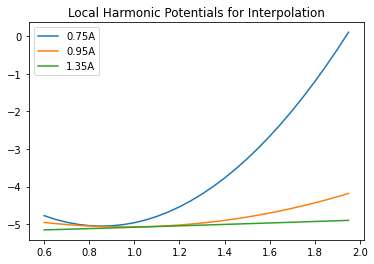

In [146]:
plt.figure(figsize=(6,4))
plt.title('Local Harmonic Potentials for Interpolation')
plt.plot(distlist, harmonic_potentials[0], label="0.75A")
plt.plot(distlist, harmonic_potentials[1], label="0.95A")
plt.plot(distlist, harmonic_potentials[2], label="1.35A")

plt.legend()
plt.show()

Let's use these for interpolation and compare to the PES calculated with XTB.

In [151]:
def get_interpolated_pes(new_point, data_points, exponent):
    # sum of all interpolation weights -- to normalize them
    sum_weights = 0
    weights = []
    potentials = []
    for q_a in data_points:
        dist = new_point - q_a
        weight = 1 / dist**exponent
        pot = get_harmonic_potential(q_a['coords'], q_a['energy'], q_a['gradient'], q_a['hessian'], new_point)
        sum_weights += weight
        weights.append(weight)
        potentials.append(pot)
        
    weights /= sum_weights

    energy = 0
    for i in range(len(data_points)):
        energy += weights[i] * potentials[i]
    
    return energy

In [154]:
xtb_energies = []
impes_energies = []

for oh in distlist:
    
    # Create new molecule
    mol_str = mol_template.replace("OHdist", str(oh))
    new_molecule = vlx.Molecule.read_str(mol_str, units='angstrom')
    
    # set-up an xtb driver, gradient driver and hessian driver
    new_xtb_drv = vlx.XTBDriver()
    new_xtb_drv.set_method(method_settings['xtb'].lower())
    new_xtb_drv.compute(new_molecule, ostream)
    
    # save the results:
    energy = new_xtb_drv.get_energy()
    
    xtb_energies.append(energy)

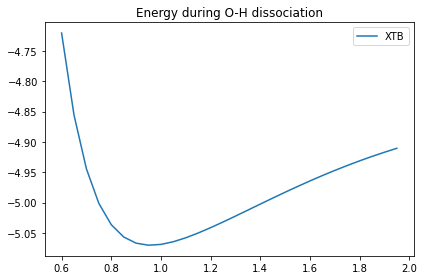

In [155]:
plt.figure(figsize=(6,4))
plt.title('Energy during O-H dissociation')
plt.plot(distlist, xtb_energies, label='XTB')
plt.legend()
plt.tight_layout(); plt.show()